<a href="https://colab.research.google.com/github/Rajaguhan437/AI-Generation_SEGmnt/blob/main/Num_Generation/code/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### importing libs

import torch
import pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


In [ ]:
!pip install wandb
#%pip install wandb

import wandb
wandb.login(key="95eda70b703e651a93829d62187e30b7bc107306")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 30.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=adfab191a80f5e86ff6a1f214acef1c7002b236daddd3e9c983c541a021720ba
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
exp_name = wandb.util.generate_id()

myrun = wandb.init(
    project = "Num-Gen",
    group = "MNIST-NUM",
    config = {
        "optimizer" : "adam",
        "model" : "MNIST-NumGen",
        "epoch" : "1000",
        "batch_size" : 128
        
    }
)

config = wandb.config

Critic_Loss,██▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▃▂▂▁▂▁▁▂▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
Gen_Loss,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▆▆▆▆▇▇▇▇██
Step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Critic_Loss,0.3779
Epoch,22
Gen_Loss,1.187
Step,5231


In [ ]:
print(exp_name)

3e51t0tf


In [ ]:
def show(tensor, ch=1, size=(28, 28), num=16, wandbactive=0, name='Image'):
    data = tensor.detach().cpu().view(-1, ch, *size) # (batch size, channels, height, width)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # (num, height, width, channels)
    
    if  wandbactive==1 :
        wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})
     
    plt.imshow(grid)
    plt.show()

In [80]:
epochs = 500
cur_step = 0
info_step = 469*5

mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64

lr = 0.00001
loss_func = nn.BCEWithLogitsLoss()

batch_size = 128
device = "cuda"

save_steps = 235*5

wandbact = 1

dataloader = DataLoader(MNIST("/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Dataset", download=True, transform=transforms.ToTensor()),batch_size=batch_size, shuffle=True)

# no. of steps = total images / batch size
# here, steps = 60000 / 256 = 234.375, took 2h 30 min for 500 epochs
# here, steps = 60000 / 128 = 468.75, took 39min for another 140 epochs



In [81]:
def genBlock( inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)    
    )

class Genrator(nn.Module):
    def __init__(self, z_dim=64, o_dim=784, h_dim=128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # 64 , 128
            genBlock(h_dim, h_dim*2), # 128, 256
            genBlock(h_dim*2, h_dim*4), # 256, 512
            genBlock(h_dim*4, h_dim*8), # 512, 1024
            genBlock(h_dim*8, h_dim*8), # 1024, 1024
            nn.Linear(h_dim*8, o_dim), # 1024, 784
            nn.Sigmoid()   
        )
        
    def forward(self, noise):
        return self.gen(noise)
    
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device)

In [82]:
## DiscBlock

def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        #nn.BatchNorm1d(out), ==> led to white block of pixels in fake imgs at starting itself.
        nn.LeakyReLU(0.2)    
    )

class Discriminator(nn.Module):
    def __init__(self, o_dim=784, h_dim=128):
      super().__init__()
      self.disc = nn.Sequential(
          discBlock(o_dim, h_dim*8), # 784 , 1024
          discBlock(h_dim*8, h_dim*4), # 1024, 512
          discBlock(h_dim*4, h_dim*2), # 512, 256
          discBlock(h_dim*2, h_dim), # 256, 128
          nn.Linear(h_dim, 1), # 128, 1
        )
        
    def forward(self, image):
        return self.disc(image)

In [83]:
gen = Genrator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [84]:
gen

Genrator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, 

In [85]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [86]:
## Weight Initialisations

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0) 
        
#gen = gen.apply(init_weights)
#critic = critic.apply(init_weights) 

In [87]:
## monitoring gradients and parameters in real time

if wandbact == 1:
    wandb.watch(gen, log_freq=100)
    wandb.watch(disc, log_freq=100)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([9, 6, 8, 1, 3, 3, 2, 2, 4, 8, 1, 1, 3, 8, 4, 4, 5, 4, 5, 7])


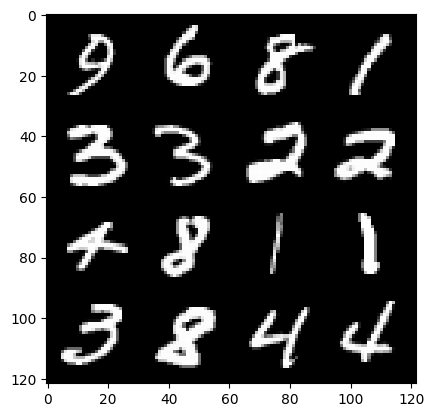

In [88]:
x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:20])
show(x)

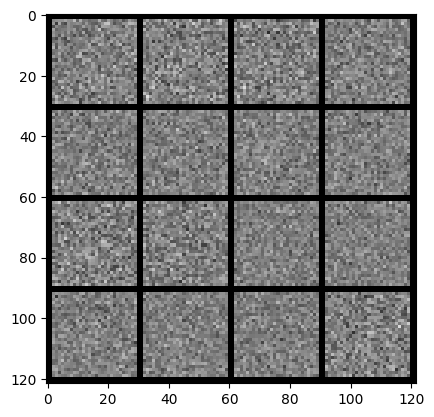

In [92]:
noise = gen_noise(batch_size, z_dim)
fake = gen(noise)
show(fake)

In [90]:
def calc_gen_loss(loss_func, gen, disc, number, z_dim):
  
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    gen_loss = loss_func(pred, targets)
    
    return gen_loss

In [93]:
def calc_disc_loss(loss_func, gen, disc, number, real, z_dim):
    
    noise = gen_noise(number, z_dim)
    fake = gen(noise)
    
    pred_fake = disc(fake.detach())
    pred_fake_targets = torch.zeros_like(pred_fake)
    pred_fake_loss = loss_func(pred_fake, pred_fake_targets)
    
    pred_real = disc(real)
    pred_real_targets = torch.ones_like(pred_real)
    pred_real_loss = loss_func(pred_real, pred_real_targets)
    
    disc_loss = (pred_real_loss + pred_fake_loss) / 2
    
    return disc_loss



In [94]:
def save_checkpoint(name, save_path):
    
    ## Generator model
    torch.save(
        {
        'epoch' : epoch, 
        'model_state_dict' :gen.state_dict(),
        'optimizer_state_dict' : gen_opt.state_dict()
        },
        save_path+'Gen-'+name+'.pkl'
    )
    
    
    ## Discriminator Model
    torch.save(
        {
        'epoch' : epoch, 
        'model_state_dict' :disc.state_dict(),
        'optimizer_state_dict' : disc_opt.state_dict()
        }, 
        save_path+'Disc-'+name+'.pkl'
    )
    
    print("Saved Checkpoint")


In [95]:
## Load Checkpoint

def load_checkpoint(name, load_path):
    
    ## Load Gen
    chkpt = torch.load(load_path+'Gen-'+name+'.pkl')
    gen.load_state_dict(chkpt['model_state_dict'])
    gen_opt.load_state_dict(chkpt['optimizer_state_dict'])
    
    ## Load Discriminator
    chkpt = torch.load(load_path+'Disc-'+name+'.pkl')
    disc.load_state_dict(chkpt['model_state_dict'])
    disc_opt.load_state_dict(chkpt['optimizer_state_dict'])
    
    print('Loaded Checkpoint')

In [ ]:
# Test save and load

save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
load_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"

epoch = 1

save_checkpoint("test", save_path)
load_checkpoint("test", load_path)

Saved Checkpoint
Loaded Checkpoint


In [96]:
load_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
load_checkpoint("NumGEN-MNIST", load_path)

Loaded Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 1175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

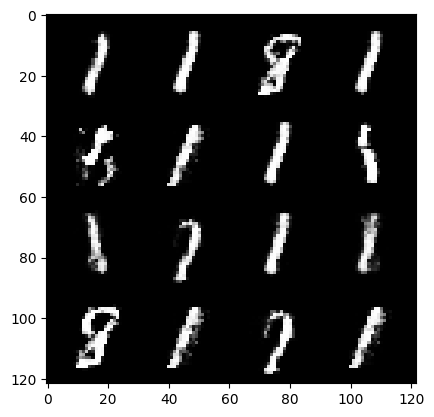

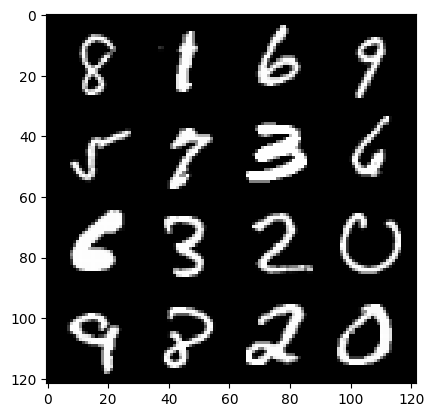

Epoch = 505 cur_step = 2345 disc_loss = 0.24139618102167207 gen_loss = 2.117685086945735
Saving Checkpoint: 2350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 3525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

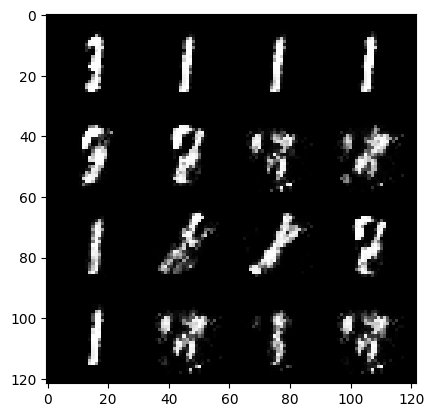

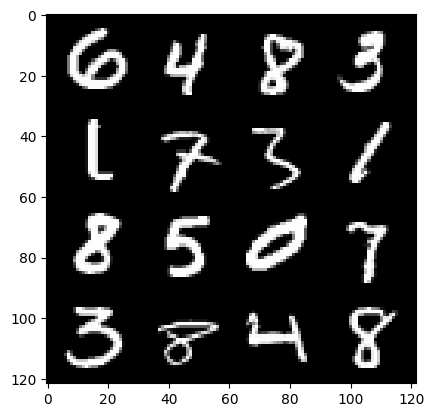

Epoch = 510 cur_step = 4690 disc_loss = 0.2806218268901809 gen_loss = 1.9526629622302838
Saving Checkpoint: 4700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 5875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

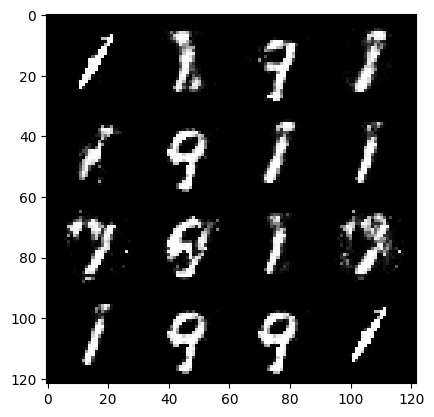

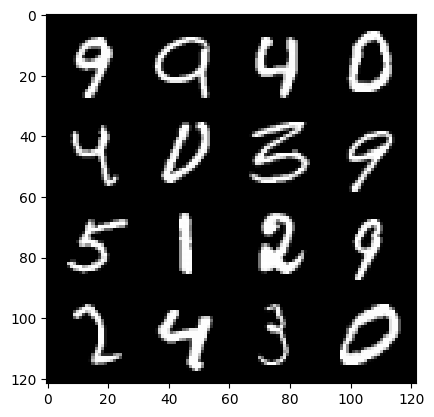

Epoch = 515 cur_step = 7035 disc_loss = 0.322279240511882 gen_loss = 1.7716828952211816
Saving Checkpoint: 7050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 8225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

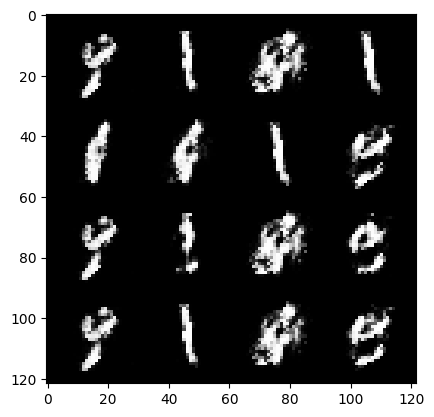

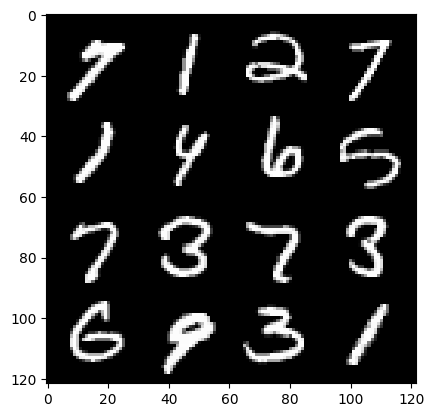

Epoch = 520 cur_step = 9380 disc_loss = 0.3046269392979933 gen_loss = 1.7985318941856498
Saving Checkpoint: 9400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 10575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

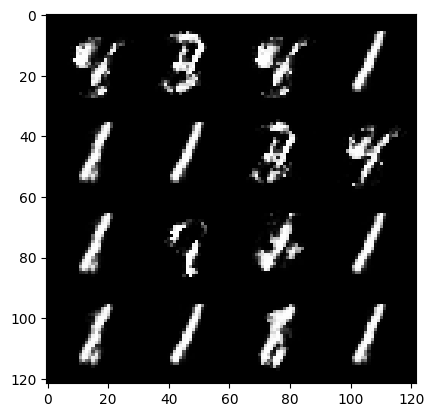

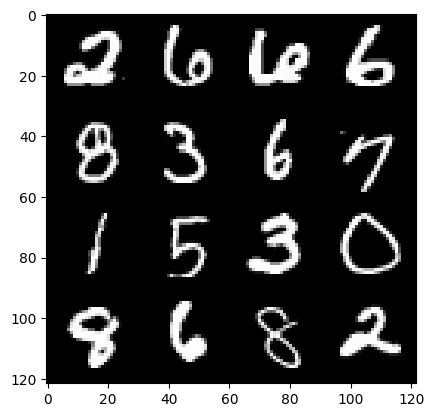

Epoch = 525 cur_step = 11725 disc_loss = 0.3110045915155777 gen_loss = 1.80201558039895
Saving Checkpoint: 11750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 12925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

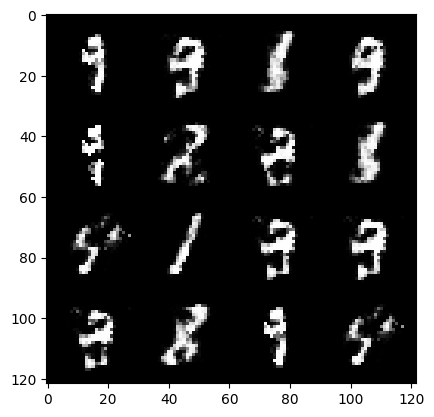

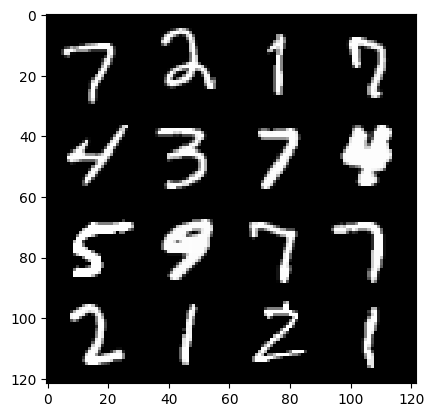

Epoch = 530 cur_step = 14070 disc_loss = 0.31770445321287427 gen_loss = 1.7677332624443558
Saving Checkpoint: 14100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 15275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

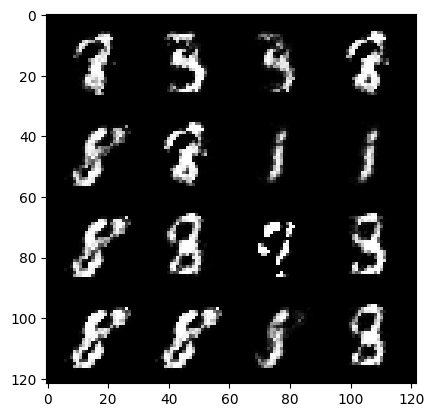

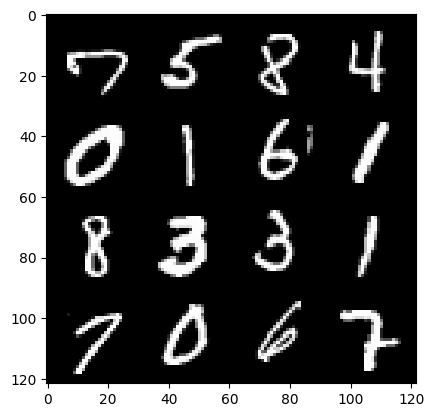

Epoch = 535 cur_step = 16415 disc_loss = 0.33930164003041763 gen_loss = 1.696856760216166
Saving Checkpoint: 16450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 17625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

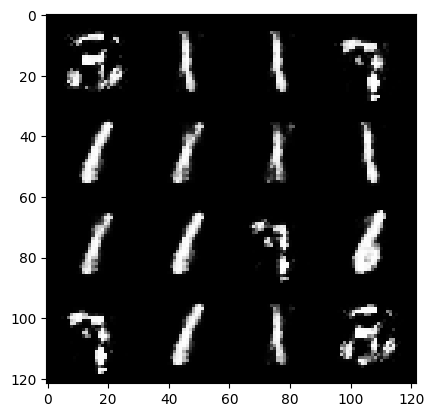

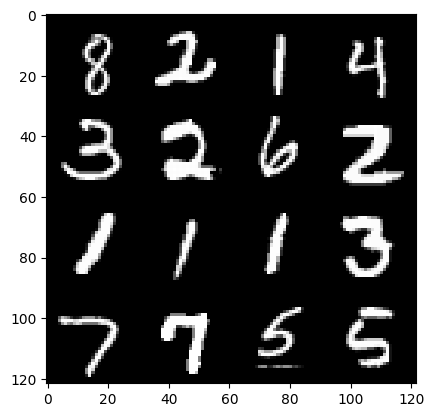

Epoch = 540 cur_step = 18760 disc_loss = 0.31356193846476865 gen_loss = 1.7844072195512655
Saving Checkpoint: 18800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 19975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

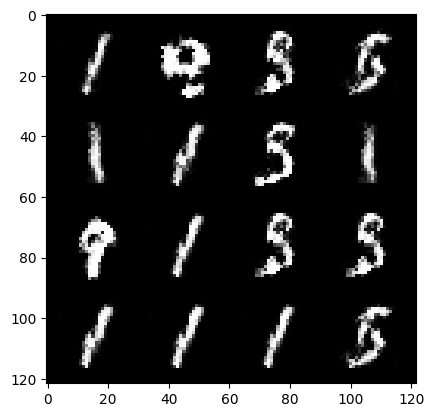

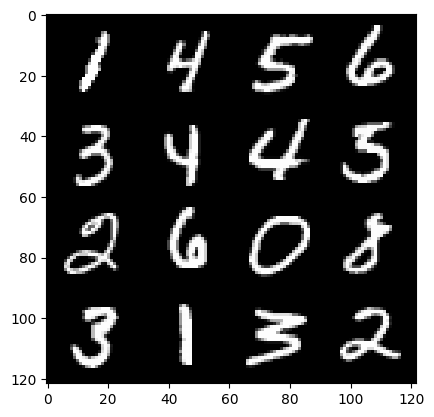

Epoch = 545 cur_step = 21105 disc_loss = 0.3372841740404365 gen_loss = 1.6594972510836017
Saving Checkpoint: 21150
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 22325
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

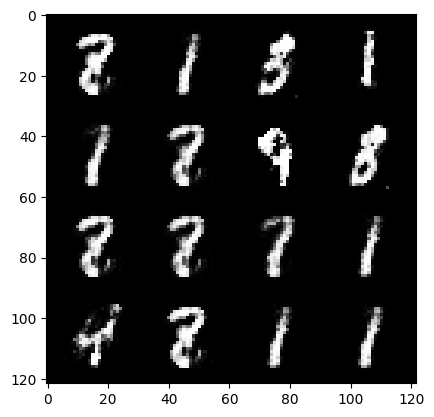

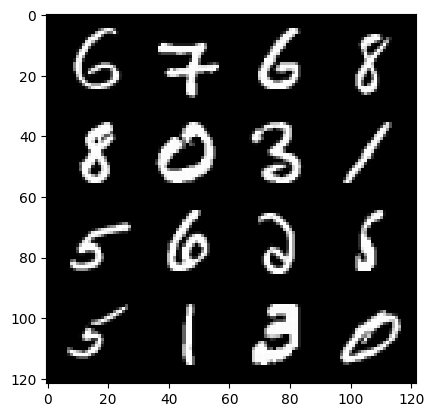

Epoch = 550 cur_step = 23450 disc_loss = 0.3136714760174375 gen_loss = 1.7972128896062562
Saving Checkpoint: 23500
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 24675
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

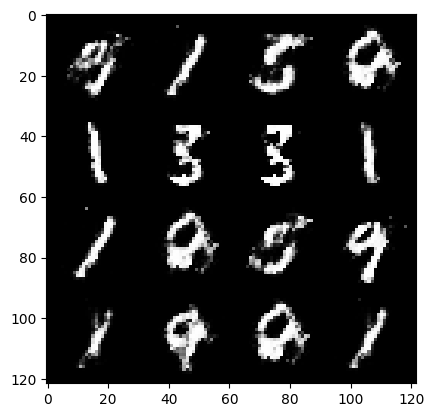

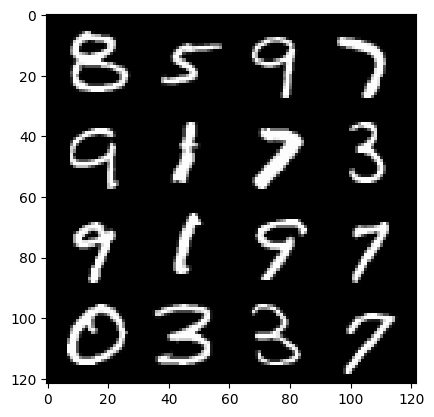

Epoch = 555 cur_step = 25795 disc_loss = 0.3265292692286119 gen_loss = 1.7340842894653776
Saving Checkpoint: 25850
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 27025
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

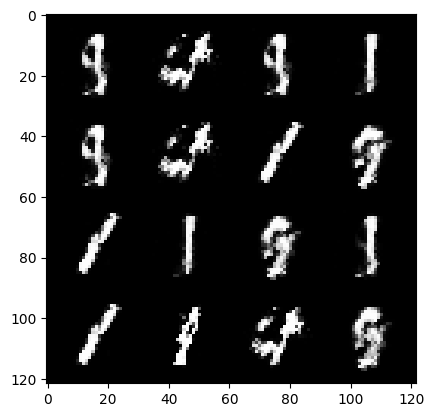

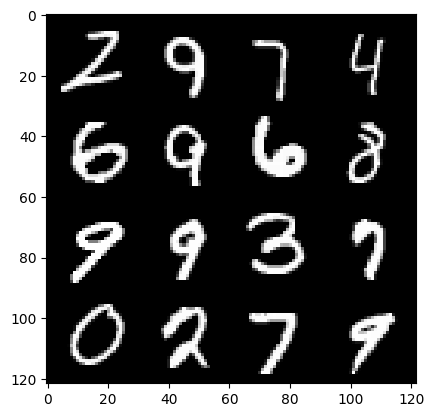

Epoch = 560 cur_step = 28140 disc_loss = 0.32735291291147406 gen_loss = 1.708648577987004
Saving Checkpoint: 28200
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 29375
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

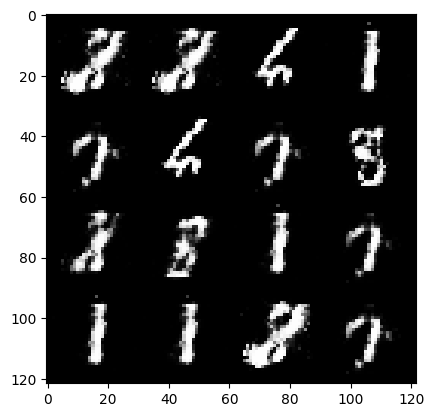

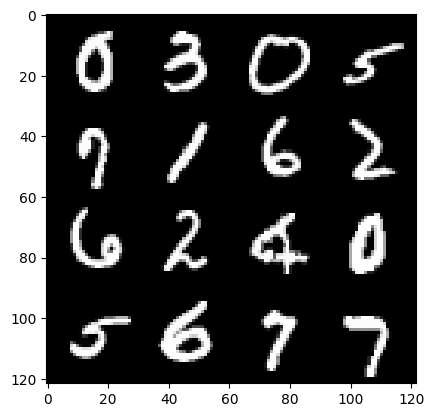

Epoch = 565 cur_step = 30485 disc_loss = 0.3290312303599518 gen_loss = 1.685492364938325
Saving Checkpoint: 30550
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 31725
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

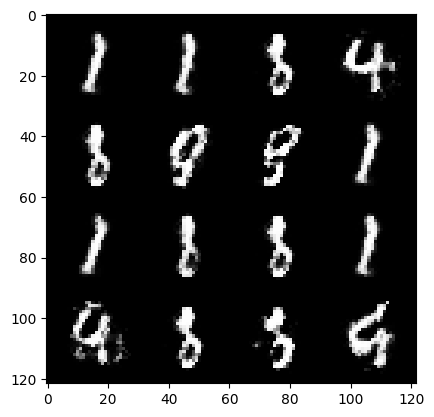

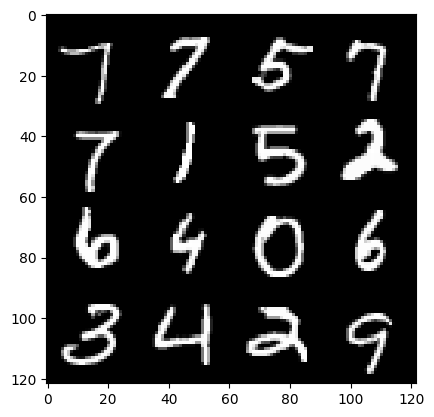

Epoch = 570 cur_step = 32830 disc_loss = 0.35224659067989667 gen_loss = 1.6266846073715926
Saving Checkpoint: 32900
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 34075
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

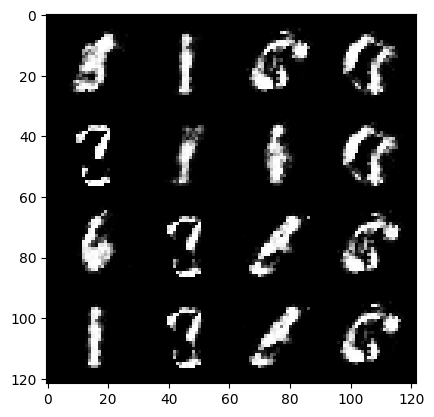

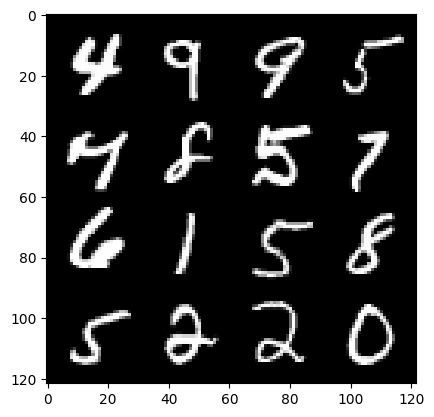

Epoch = 575 cur_step = 35175 disc_loss = 0.34858119091880857 gen_loss = 1.6399663122986425
Saving Checkpoint: 35250
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 36425
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

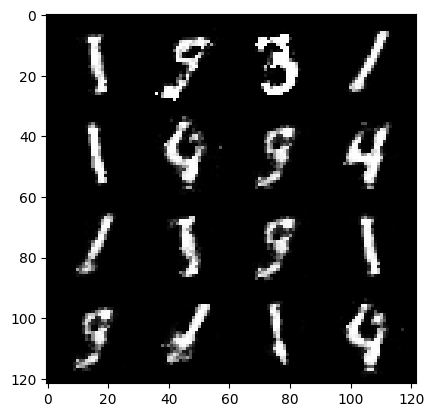

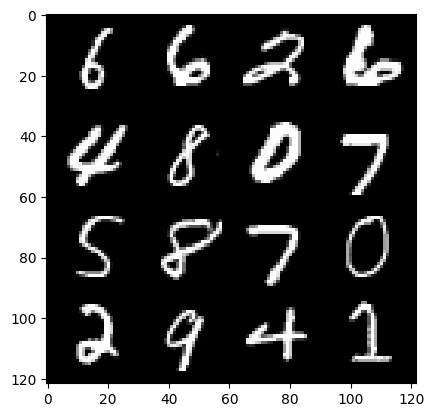

Epoch = 580 cur_step = 37520 disc_loss = 0.3352880920110735 gen_loss = 1.6763352115525365
Saving Checkpoint: 37600
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 38775
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

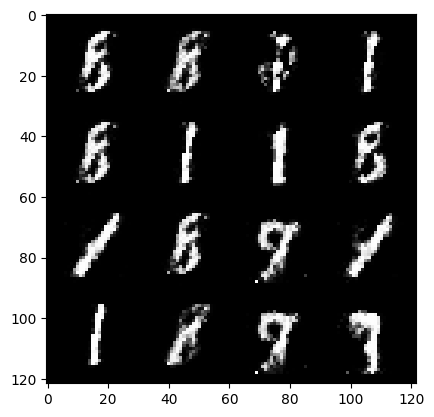

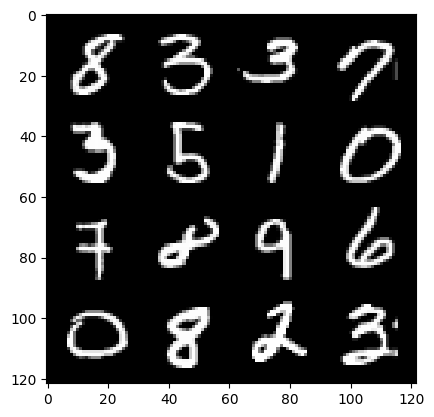

Epoch = 585 cur_step = 39865 disc_loss = 0.348321468349713 gen_loss = 1.644517227479898
Saving Checkpoint: 39950
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 41125
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

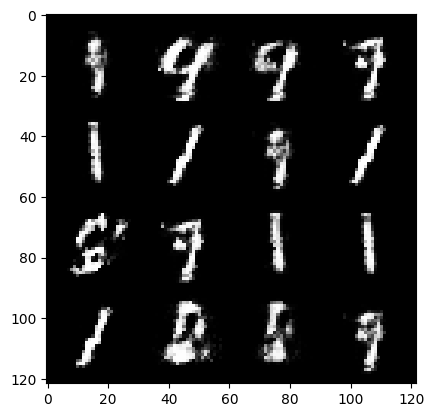

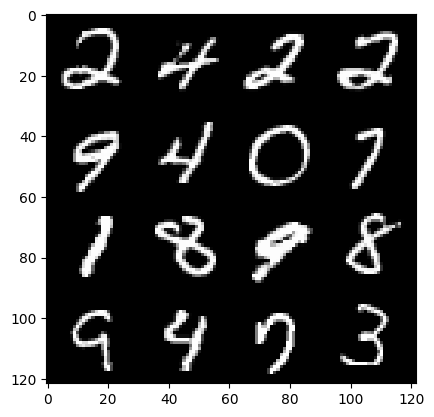

Epoch = 590 cur_step = 42210 disc_loss = 0.3644551429285932 gen_loss = 1.5851938657923295
Saving Checkpoint: 42300
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 43475
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

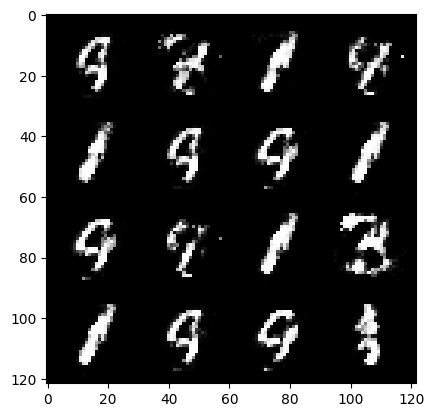

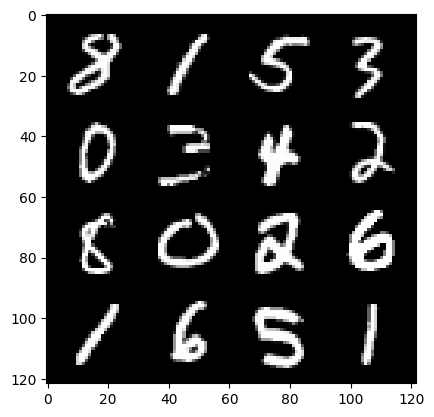

Epoch = 595 cur_step = 44555 disc_loss = 0.3958822146280488 gen_loss = 1.4754828246671763
Saving Checkpoint: 44650
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 45825
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

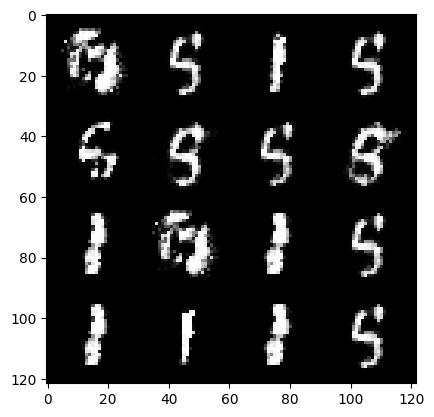

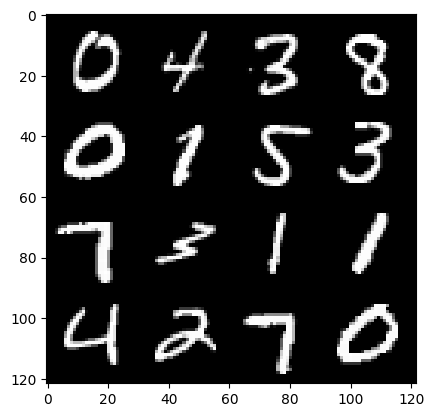

Epoch = 600 cur_step = 46900 disc_loss = 0.3390042064667765 gen_loss = 1.691526456529906
Saving Checkpoint: 47000
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 48175
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

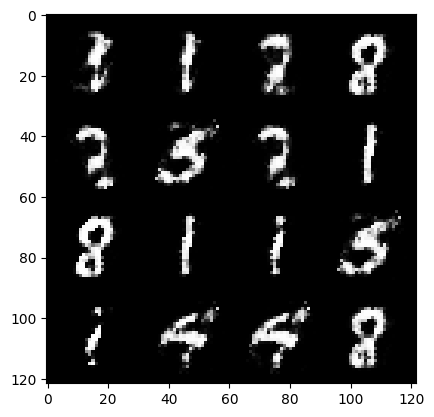

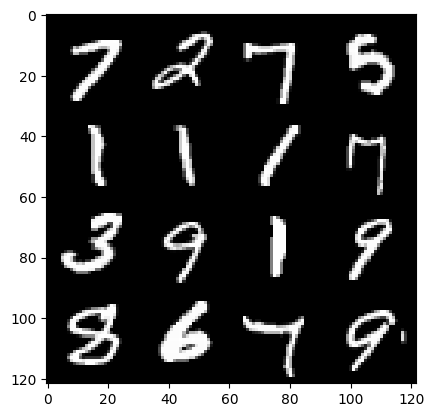

Epoch = 605 cur_step = 49245 disc_loss = 0.31287617995413636 gen_loss = 1.816498073535179
Saving Checkpoint: 49350
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 50525
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

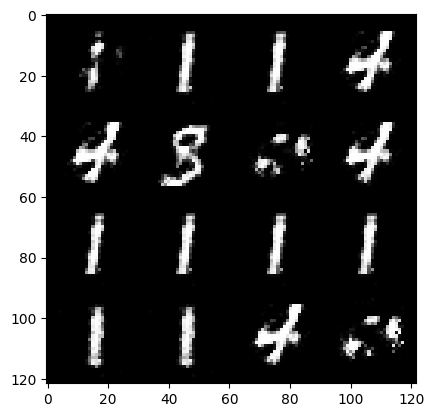

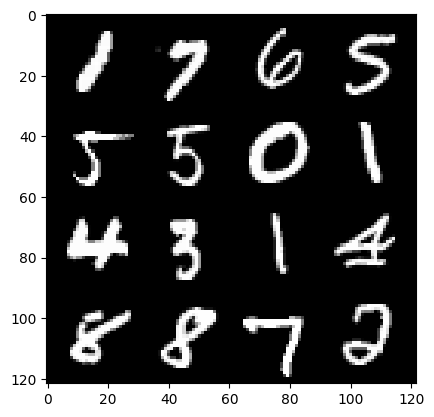

Epoch = 610 cur_step = 51590 disc_loss = 0.30512505916517174 gen_loss = 1.8115410561246403
Saving Checkpoint: 51700
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 52875
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

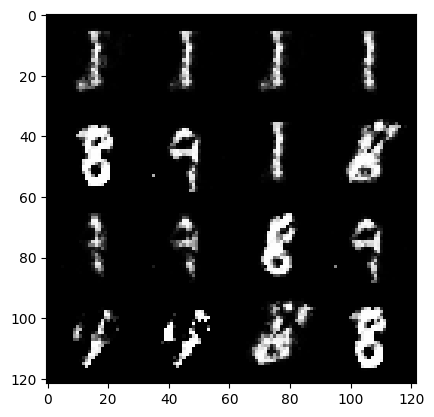

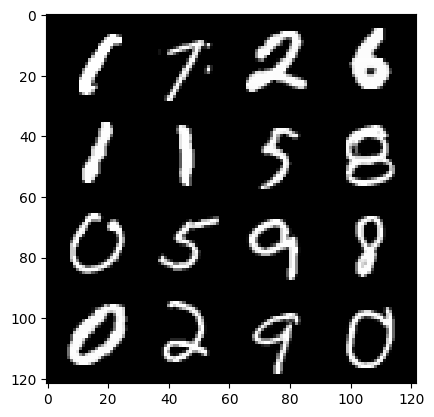

Epoch = 615 cur_step = 53935 disc_loss = 0.330839696882376 gen_loss = 1.722359016404223
Saving Checkpoint: 54050
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 55225
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

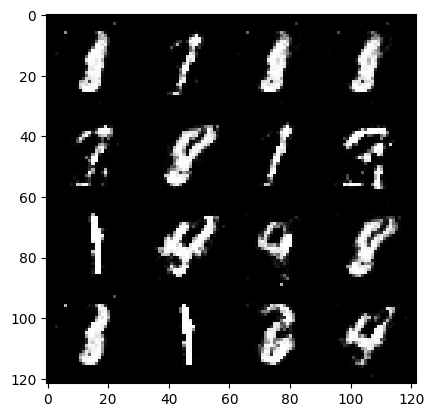

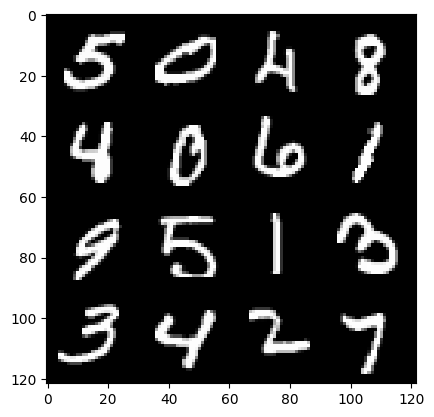

Epoch = 620 cur_step = 56280 disc_loss = 0.3281598939506738 gen_loss = 1.7256275835830266
Saving Checkpoint: 56400
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 57575
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

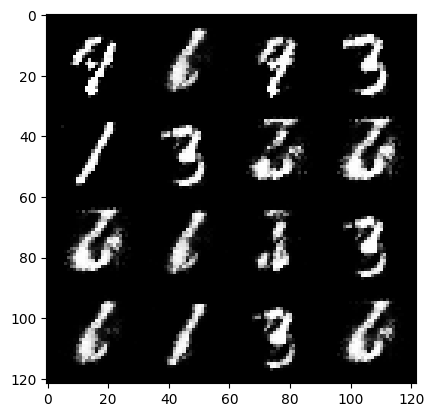

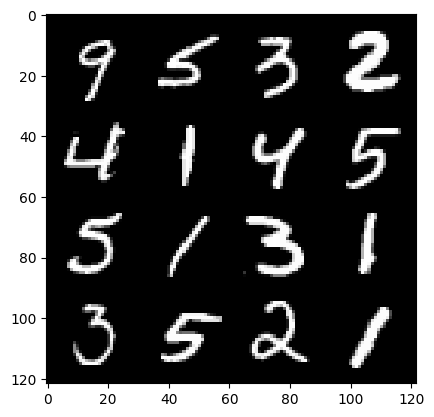

Epoch = 625 cur_step = 58625 disc_loss = 0.30436309999240235 gen_loss = 1.8485850949277247
Saving Checkpoint: 58750
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 59925
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

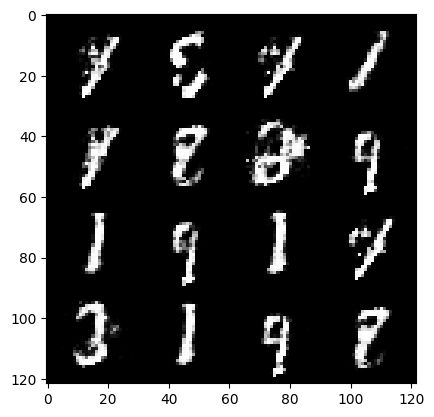

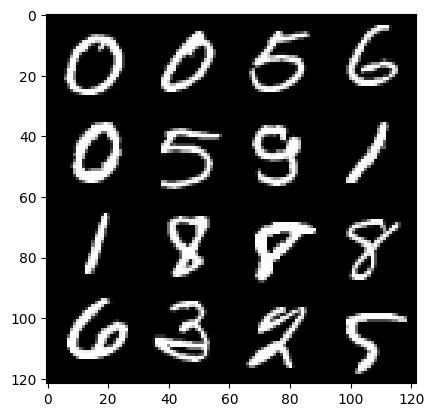

Epoch = 630 cur_step = 60970 disc_loss = 0.3279631987627127 gen_loss = 1.711273208965879
Saving Checkpoint: 61100
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 62275
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

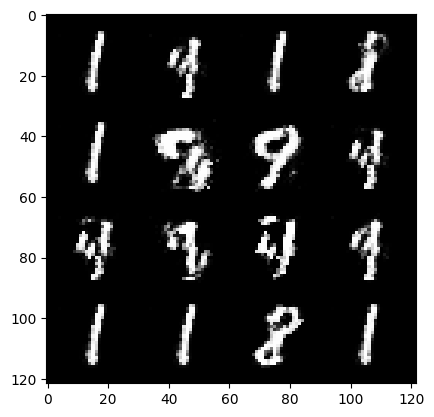

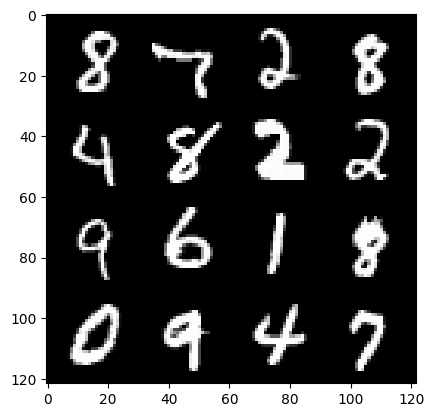

Epoch = 635 cur_step = 63315 disc_loss = 0.3613721667576446 gen_loss = 1.6194485019264953
Saving Checkpoint: 63450
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 64625
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

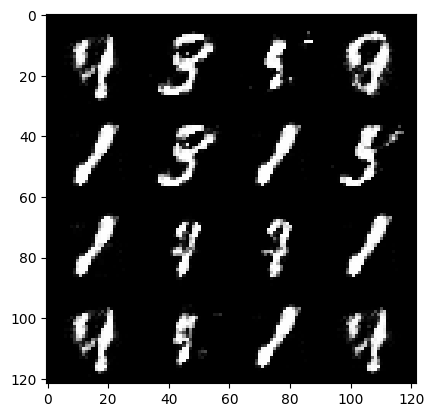

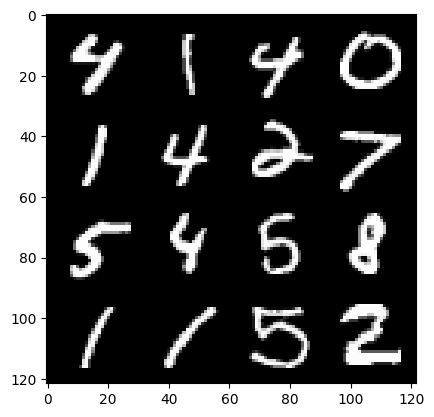

Epoch = 640 cur_step = 65660 disc_loss = 0.34125672456806405 gen_loss = 1.682913777823133
Saving Checkpoint: 65800
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Saving Checkpoint: 66975
Saved Checkpoint


  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"

for epoch in range(500, epoch+500):
    for real_img, labels in tqdm(dataloader):
        
        cur_bs = len(real_img)
        real_img = real_img.view(cur_bs, -1)
        
        ### Discrimnator
        disc_opt.zero_grad()
        real_img = real_img.to(device)
        
        disc_loss = calc_disc_loss(loss_func, gen, disc, cur_bs, real_img, z_dim)
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        ### Generator
        gen_opt.zero_grad()
        
        gen_loss = calc_gen_loss(loss_func, gen, disc, cur_bs, z_dim)
        
        gen_loss.backward(retain_graph=True)
        gen_opt.step()
        
        ### visualisation & stats
        mean_disc_loss += disc_loss.item()
        mean_gen_loss += gen_loss.item()
        
        if cur_step % info_step == 0 and cur_step > 0:
            fake_noise = gen_noise( cur_bs, z_dim)
            fake = gen(fake_noise)
            show(fake, wandbactive=1 , name='fake')
            show(real_img, wandbactive=1 , name='real')
            print("Epoch =",epoch,"cur_step =",cur_step, "disc_loss =",mean_disc_loss/info_step, "gen_loss =",mean_gen_loss/info_step  )
            mean_gen_loss = 0
            mean_disc_loss = 0

        if cur_step % save_steps == 0 and cur_step > 0:
            print("Saving Checkpoint:", cur_step)
            save_checkpoint("NumGEN-MNIST", save_path)

        if wandbact == 1:
            wandb.log({'Epoch' : epoch, 'Step' : cur_step, "Critic_Loss" : disc_loss, "Gen_Loss" : gen_loss })
            
        cur_step += 1

In [79]:
save_path = "/content/drive/MyDrive/Colab Notebooks/AI-Generation_SEGmnt/Num_Generation/Model/"
save_checkpoint("NumGEN-MNIST", save_path)

Saved Checkpoint
